CS412 TERM-PROJECT POLILITICAL TWEET AND BOT ACCOUNT DETECTION MODEL

Yasin Albayrak

In this notebook, we have worked on the models for political tweet prediction and bot account prediction. Most of the explanatory data analysis part that we worked on are not included. Here you can see only the necessary parts to make data ready for prediction and the model that is used for predictions. All other models that is tried (got lower accuracy) is either deleted or not included in this notebook. **kalın metin**

In [193]:

import fontstyle
print('Before we start :)\n')
text = fontstyle.apply(
    'Onur Hocam Thank you a lot for all effort and energy you put during this great semester', 'bold/Italic/red/INVERSE/2UNDERLINE/GREEN_BG')
 
# display text
print(text)

 

Before we start :)

Onur Hocam Thank you a lot for all effort and energy you put during this great semester


# 0. Initialize

## 0.1. Import Libraries

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from google.colab import drive
from datetime import datetime

## 0.2. DEFINE VARIABLES 

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/CS412/CS412_PROJECT/' # '<insert-your-training-data-path-here>'

ROUND = 3 # This project will have 3 rounds of predictions: 1,2,3
STUDENT_ID = '27943'#'<insert-your-id-here>'
PROJECT_CODE = 'CS4128c080c54e79e'#'<insert-your-code-here>' # Same code for the annotation eg. CS412xxxxx

Mounted at /content/drive


In [4]:

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'drive', 'sample_data']


## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [5]:
#trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH))
trainingTweetDf = pd.read_csv('{}Copy of training-tweet.csv'.format(DATA_PATH), dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf

,tweet_id,isPolitical
0,1597170281545551872,Yes
1,1431700027471192069,No
2,1566035577090281472,Yes
3,1591538690869940225,Yes
4,1583898169238167554,Yes
...,...,...
2995,1593539327623151619,Yes
2996,1393886554062524418,No
2997,1597925615092764672,Yes
2998,1585291418616176640,Yes


In [6]:
trainingTweetDf.isPolitical.value_counts()

Yes    2003
No      997
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [7]:
trainingUserDf = pd.read_csv('{}Copy of training-user.csv'.format(DATA_PATH))
#trainingUserDf = pd.read_csv('training-user.csv')
trainingUserDf

,screen_name,isBot
0,koftecancaddy,No
1,ahaber,No
2,selahat03949652,No
3,erdin06357062,No
4,bhct__necatii,No
...,...,...
2995,djblumenberg,No
2996,mel1sq,No
2997,eren_yz1,Yes
2998,ergnyildiz4,No


In [8]:
trainingUserDf.isBot.value_counts()

No     2424
Yes     576
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

In [9]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

print('http://www.onurvarol.com/Annotation-CS412-202201/reports/report_{}.html'.format(PROJECT_CODE))

http://www.onurvarol.com/Annotation-CS412-202201/reports/report_CS4128c080c54e79e.html


# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

In [10]:
PATH_TO_DOWNLOADED = DATA_PATH # 'D:/Users/suuser/Desktop/Sabancı/CS412/spring-2022/project/'

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [11]:
import json
import gzip
a = 0
with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        for i,z in line.items():
          print(str(i) + ': ' + str(z))
        print('\n')

        if(a==10):
          break
        a= a+1

created_at: Fri Nov 04 16:28:09 +0000 2022
id: 1588568792984346624
id_str: 1588568792984346624
text: Sosyal Hizmetin temelini çocuk oluşturur,çocuğun biyopsikososyal  gelişim temellerinin atıldığı eğitim-öğretim haya… https://t.co/BjpnjmPfL0
truncated: True
entities: {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/BjpnjmPfL0', 'expanded_url': 'https://twitter.com/i/web/status/1588568792984346624', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}
source: <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
in_reply_to_status_id: None
in_reply_to_status_id_str: None
in_reply_to_user_id: None
in_reply_to_user_id_str: None
in_reply_to_screen_name: None
user: {'id': 920963718103650304, 'id_str': '920963718103650304', 'name': 'Zeycak1611', 'screen_name': 'Maviruh_', 'location': 'Ankara', 'description': 'shu/\nburaya afilli bir söz yazdığımı varsayın', 'url': None, 'entities': {'description': {'urls': []

In [12]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
               
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [13]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [14]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [15]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [16]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [17]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']

    return id, screen_name, description

#### 1.1.1.7. Get Langugae of Tweet





In [18]:
def get_language(tweet_metadata_line):
  language = 'unknown'
  try:
      language = tweet_metadata_line['lang']
  except KeyError:
      pass
  return language  

#### 1.1.1.8. Get User Mentions


In [19]:
def get_user_mensions(tweet_metadata_line):
  mentions = None
  try:
    mentions = tweet_metadata_line['entities']['user_mentions']
  except KeyError:
    pass

  return mentions

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [20]:
#political entities

list_of_entities = ['meral_aksener', 'ekrem_imamoglu',
                    'kilicdarogluk', 'vekilince', 'dravsaraslan',
                    'RTErdogan', 'MevlutCavusoglu', 'omerrcelik',
                    'umitozdag','suleymansoylu', 'tubavuralcokal',
                    'fsdenizolgun','drfahrettinkoca' , 'NumanKurtulmus',
                    'eczozgurozel', 'sgirgin48tbmm',
                    'fethigurer','veliagbaba','herkesicinCHP',
                    'dbdevletbahceli', 'kamilaydinmhp','mahirunal',
                    'ikalin1', 'fuatoktay','TC_Disisleri', 
                    'alibabacan','06melihgokcek','varank','Ümit Özdağ','umit ozdag', 
                    'kasapoglu','vedatbilgn',
                    'akaraismailoglu', 
                    'Ahmet_Davutoglu' ,'BMustafaGozel','kentsel dönüşüm','kentsel donusum',
                    'Putin','ÖTV','KDV','otv','kdv','vergi','#112AÇMyeBölMezunuŞart','fetö','feto',
                    'fahrettinaltun','tuncsoyer','Bedelli Askerlik', 'AvOzlemZengin' ,'@SezaiTemelli',

                    'tcmeb', 'AKP','MHP', 'CHP', 'Parti','seçim','secim','HDP','Ak parti','zaferpartisi',
                    ' ak ', ' akp ', ' chp ', ' hdp ', ' mhp ', 'iyi parti', ' NATO ',
                    'AKGenclikGM', 'Akparti', 
                    'emrullahisler' ,'vasipsahin', ' iyiparti ',
                    'Ekrem', 'imamoglu','imamoğlu','Imamoglu', 'erdoğan','tayyip',' rte ','kılıçdaroğlu',
                    'mansuryavas06','bakan','mbulentkaratas ','dfikrisaglar',
                    'siyaset','politika',' Soylu ',
                    # political words
                    'vatandaş','eyt', 'staj','genel af',  'kpss','KYK','Demokrasi',
                    'Rejim','MANSUR','VahitKirisci',  
                    'kontenjan','Meral Akşener', 'bybekirbozdag ', 'arzuerdemDB', 'gergerliogluof', 
                     'emekli öğretmen', 'maaş',
                    'millet ittifakı', 'cumhur ittifakı', 'ek atama', 'Kılıçdaroglu','Bahçeli', 'sehit', 'şehit',
                    #mülteci

                     'Cumhurİttifakı' 'BekirBozdağ' ,'AdaletBakanı','TBMMresmi', ' Yunan', 'MBekaroglu',
                      'mülteci', 'suriye', 'dış işleri', 'dıs isleri', 'iran', 'diktatörlük', 'dictatorship',
                      'dünya gündemi', 'Donald Trump', 'Joe Biden', 'amerika', 'dış güçler', 'Avrupa Birliği', 
                      'European Union', 


                    #trending hashtags 
                    
                     'bay Kemal','Afgan','enginozkoc','yilmaztunc',' oy ',' oyum ','milletvekili','belediye başkanı',
                    'vekilmahirpolat','Hayati_Yazici','TCAytunCiray','LutfuTurkkan','Ozturkdenizli','osmannnurika','celebimehmeta','Biden','Joe Biden',
                    'Adil yargılanma','Yargıtay','avabdullahguler','avunzileyuksel','AvOzlemZengin','cumhuriyet','s_turpcu','barisatay','meclis','HillaryClinton','muhalefet',
                    'kayyum','NureddinNebati','devlet','meraldanis','BBahadirErdem','MBekaroglu',
                    'MSTanrikulu','SelimYagci11','senerabdullatif','erhanusta','FahrettinYokus','15 Temmuz','darbe','murat_kurum','akbasogluemin',
                    'tipgenelmerkez',' TİP ','Vatan Partisi', 'Gelecek PArtisi', 'avaliozkaya','Sibelyigitalp', 'GultekinUysal','alimahir',
                    'Canan_Kaftanci','Kadro','Vekil','terörist', 'SAĞCI', 'Tarım','OlcayKilavuz', ' yasa ', ' yasası ', ' yasasını ', ' yasaları ', 'atama',
                    'diktatör','kilicdaroglu', 'Atatürk', 'ataturk','PKK','YPG' ,' Aday ', 'ülke',
                    'GenelAf', ' Koca ', ' Altılı ', 'altılı masa','Mustafa_Destici',
                    'Hukuk', 'Millet', 'şehit', 'ayhanbilgen',' dolar',
                    ' af ', 'ayyildirim1', 'Engelli Öğretmen',
                    'oguzksalici' , 'eğitim', 'Türkiye', 'İmamoğlu', 'Mahkum', 'mehmetozhaseki', 'memur',
                    'sağlık','ekonomi','başkan', ' Türk' ,
                    'elit','mkulunk',
                    'fox', 'AKistteskilat','haklar', 'mezun' ,'sözleşme', 'prezident', 'president',' RECEP ', 'TAYYİP','TAYYIP' ,
                     'başkanım'
                    
                    ]

In [21]:
def replying_to(tweet_metadata_line):
  reply_to = tweet_metadata_line['in_reply_to_screen_name']
  if reply_to:
    
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in reply_to.lower()]

    number_entities = len(entities_in_text)

    if number_entities >= 1  :
      return 1
      
    return 0 
  else:
    return 0

In [22]:
def check_political_ent(text,mentions):
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)
    return number_entities 

In [23]:
def check_description_politcal(description_text):
  entities_in_text = [ent for ent in list_of_entities if ent.lower() in description_text.lower()]
  
  number_entities = len(entities_in_text)
  

  return number_entities 

In [24]:
def is_retweeted_from_politics(retweeted_username):



  if(retweeted_username):
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in retweeted_username]
    if len(entities_in_text) >= 1:
      return True
    else:
      return False
  else:
    return False

In [25]:
def ratio_of_political_words_to_whole(text,mentions):
    total_political_entity_number = check_political_ent(text,mentions)
    words_set_length = len(set(text.split()))

    return total_political_entity_number/words_set_length

#### 1.1.2.2. Number of total interactions

In [26]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [27]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'text':[],
              'num_mentions':[],
              'num_hashtags':[],#
              'num_retweets':[],
              'num_favorites':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'num_political_entities':[], #
              'total_interactions':[], #
               'content_language':[],
               'ratio_of_political':[],
               'is_retweeted_from_politics':[],
               'check_description_politcal':[],
               'replying_to_political': []
               }


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description = get_user_info(line)
        language = get_language(line)
        mentions = get_user_mensions(line)
        ratio_of_political_word = ratio_of_political_words_to_whole(text,mentions)

        # manually crafted data:
        num_political_entities = check_political_ent(text,mentions)
        total_num_interactions = total_interactions(retweet_count, favorite_count)

        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['content_language'].append(language)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['total_interactions'].append(total_num_interactions)
        dfPolitical['ratio_of_political'].append(ratio_of_political_word)

        is_retweeted_from_politics1 = is_retweeted_from_politics(retweeted_username)
        check_description_politcal1 = check_political_ent(user_description,mentions) 
        dfPolitical['is_retweeted_from_politics'].append(is_retweeted_from_politics1)
        dfPolitical['check_description_politcal'].append(check_description_politcal1)   

        reply_to = replying_to(line)
        dfPolitical['replying_to_political'].append(reply_to)      



In [28]:
dfPolitical = pd.DataFrame(dfPolitical)

In [29]:
#some examinations about tweets

dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical[dfPolitical['num_political_entities']>0] 
#dfPolitical 15644-15062-14579-14491-14524-14108-13691-13425-13091-12751-12456
dfPolitical.head(40)[['text','num_political_entities']]
print(1- (dfPolitical[dfPolitical['num_political_entities']== 0]['text'].count() / dfPolitical['text'].count() ))
print( dfPolitical[dfPolitical['num_political_entities']== 0  ]['text'].count()  )
print( dfPolitical[dfPolitical['check_description_politcal']== 0  ]['text'].count())
dfPolitical[dfPolitical['num_political_entities']== 0]['text'].iloc[1650:1710] 

0.7132675275102138
9615
27656


5866    Meghan Trainor, doğum yaptığını Instagram hesa...
5867         Tamam kalkın o zaman https://t.co/XO8taYwlIY
5870    @eso_loji @gnyhnm Esoomm balımmmm baktm hatunl...
5873           Doğruyu söyledi👏👏👏 https://t.co/MOlDM4K98e
5877                             @ayiyomii Neden olmasın?
5880                           @gazeteduvar Olduremedi ya
5901    duygusal keyifsizlik..sinirli değilsin agresif...
5907    @dirilispostasi @teslaownersSV @elonmusk I sen...
5908    Herkes sevgilisiyle foto paylaşmış hayırdır bi...
5911       @egombilir evli kezban kadınlar hiç çekilmiyor
5912    @BY #ŞahinbeyinAKGençleri olarak Geçmiş olsun ...
5918    @DIBAliErbas Başarılı fakat Atanamaz denerek y...
5922                  @yusuf_filikci Ciğerim yandı yine 💔
5923           @serdareedus sağol tercüme için amınakoyim
5924    @samiltayyar27 Bence Kapatın gitsin belediyele...
5929                 @ugurfakii Tam bir Friday ortamı 🥂㊗️
5931    Mahmut Özer Umut verip güven asılıyıpta yarı y...
5936          

## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

In [30]:
import json
import gzip
a = 0;
with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:

      line = json.loads(line)
      for i,z in line.items():
        print(str(i) + ': ' + str(z))
     
      print('\n')
    
      if(a==3):
        break
      a= a+1

id: 1431241870848450577
id_str: 1431241870848450577
name: Nasreena Khan Wazir
screen_name: NasreenaKhan006
location: Islamabad, Pakistan
description: Student
url: None
entities: {'description': {'urls': []}}
protected: False
followers_count: 65
friends_count: 185
listed_count: 0
created_at: Fri Aug 27 13:07:30 +0000 2021
favourites_count: 17676
utc_offset: None
time_zone: None
geo_enabled: True
verified: False
statuses_count: 2551
lang: None
status: {'created_at': 'Sun Dec 11 06:06:33 +0000 2022', 'id': 1601820715174748162, 'id_str': '1601820715174748162', 'text': '@pmln_org Lati b apni behns b insaf hi hoga', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'pmln_org', 'name': 'PML(N)', 'id': 497658491, 'id_str': '497658491', 'indices': [0, 9]}], 'urls': []}, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'in_reply_to_status_id': 1601556507451363330, 'in_reply_to_status_id_str': '160155

#### 1.2.1.1. Get user info metadata

In [31]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']
    
    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count}

    return dictionary

#### 1.2.1.2. Get account creation time

In [32]:
def get_creation_time(user_metadata_line):
  splitted = user_metadata_line['created_at'].split(' ')
  creation_time =splitted[2]+ '/'+ month_detection(splitted[1]) + '/' +splitted[-1]

  return creation_time

In [33]:
def month_detection(month) :
  if month == "Jan" :
    return "01"
  elif month == "Feb":
    return "02"
  elif month == "Mar":
    return "03"
  elif month == "Apr":
    return "04"
  elif month == "May":
    return "05"
  elif month == "Jun":
    return "06"
  elif month == "Jul":
    return "07"
  elif month == "Aug":
    return "08"
  elif month == "Sep":
    return "09"
  elif month == "Oct":
    return "10"
  elif month == "Nov":
    return "11"
  elif month == "Dec":
    return "12"
  else:
    return "Unknown"

#### 1.2.1.3. Get whether account is verified

In [34]:
def check_if_verified(user_metadata_line):
  isverified = user_metadata_line['verified']
  
  return isverified

#### 1.2.1.4. Get whether account uses default profile image

In [35]:
def check_default_profile_image(user_metadata_line):
  is_default_profile_image = user_metadata_line['default_profile_image']
  return is_default_profile_image


#### 1.2.1.5. Get whether account uses default profile 

In [36]:
def check_default_profile(user_metadata_line):
  isDefault = user_metadata_line['default_profile']
  return isDefault

#### 1.2.1.4. Get followers/(followers+friends) ratio

In [37]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.5. Get Tweets' Count

In [38]:
def get_status_count(line):
  tweets_count = line['statuses_count']
  return tweets_count

#### 1.2.1.5. Get description length

In [39]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

#### 1.2.1.6. Get tweet per day

In [40]:
def get_tweet_count_per_day(created_at,tweet_count):
  retrived_day = datetime.strptime('13/12/2022', '%d/%m/%Y')
  created_at = datetime.strptime(created_at, '%d/%m/%Y')
  ratio_per_day =float(tweet_count )/(retrived_day - created_at).days
  return ratio_per_day





In [41]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[],
         'created_at':[],
         'is_verified':[],
         'is_default_profile_image': [],
         'is_default_profile': [],
         'total_tweet_count': [],
         'tweet_per_day': []
         }

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        created_at = get_creation_time(line)
        dfBot['created_at'].append(created_at)
        
        is_verified = check_if_verified(line)
        dfBot['is_verified'].append(is_verified)

        is_default = check_default_profile(line)
        dfBot['is_default_profile'].append(is_default)

        is_default_profile_image = check_default_profile_image(line)
        dfBot['is_default_profile_image'].append(is_default_profile_image)

        tweet_count = get_status_count(line)
        dfBot['total_tweet_count'].append(tweet_count)

        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

        per_day_tc = get_tweet_count_per_day(created_at,tweet_count)
        dfBot['tweet_per_day'].append(per_day_tc)

        


In [42]:
dfBot = pd.DataFrame(dfBot)

dfBot



,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,created_at,is_verified,is_default_profile_image,is_default_profile,total_tweet_count,tweet_per_day
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,7,0.260000,27/08/2021,False,False,True,2551,5.393235
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,19,0.732260,11/09/2020,False,False,True,42771,51.969623
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,64,0.192308,10/04/2019,False,False,True,14300,10.647803
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,65,0.325203,29/01/2016,False,False,True,21303,8.487251
4,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,23,0.505051,01/12/2013,False,False,True,1629,0.493786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,,,229,217,0,0.513453,26/10/2020,False,False,True,2396,3.079692
29666,111074128,Melda Onur,meldaonur,,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,100,0.975088,03/02/2010,False,False,False,75178,16.008944
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,28,0.451362,01/05/2009,False,False,False,6482,1.303177
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,116,0.314431,14/03/2014,False,False,True,121113,37.895181


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of mentions to all tweets

In [43]:
def get_number_of_mentions_ratio(line, tweet_count):
  nofMentions = 0;
  for tweet in line['tweets']:
    mentions = tweet['entities']['user_mentions']
    nofMentions += len(mentions)
  

  if  tweet_count == 0:
    return None
  else:
    return float(nofMentions) / tweet_count

      
    

#### 1.2.2.2. Check ratio of interaction to all tweets (likes + retweets) / tweets

In [44]:
def interaction_per_post(like_count,retweet_count):
  if like_count != None and retweet_count != None:
    return (like_count + retweet_count )
  else:
    return None


#### 1.2.2.3. Check ratio of retweets to all tweets

In [45]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

#### 1.2.2.4. Check median number of favorites

In [46]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

#### 1.2.2.5. Check ratio of likes per tweet

In [47]:
def like_per_post(line,tweet_count):
  total_like_count = 0
  for tweet in line['tweets']:
      
    total_like_count += tweet['favorite_count']

  if tweet_count != 0:
    ratio = float (total_like_count) / float(tweet_count)      
  else:
    ratio = None; 

  return ratio
            

#### 1.2.2.6. Check the count of different sources used

In [48]:
def get_source(line):

  sources = [] 
  for tweet in line['tweets']:
    buffer = tweet['source']
    buffer = buffer[buffer.find('>',buffer.find('rel'))+1: buffer.find('<',buffer.find('rel'))]
    if buffer not in sources:
      sources.append(buffer)
  return len(sources)  

  

#### 1.2.2.7. Check any duplicate posts and mean number of duplication



In [49]:
def get_duplicate_posts(line):
  duplicates =  {}
  count = 0

  for tweet in line['tweets']:
    tweet_text = tweet['text']
    is_exceeded = tweet['truncated']
    if is_exceeded:
      tweet_text = tweet_text[:tweet_text.find('https://')]

    if tweet_text not in duplicates.keys():
      duplicates[tweet_text] = 1
    else:
      duplicates[tweet_text] += 1
    
  duplicate_mean = 0
  if duplicates: # if the list not empty
    for i,j in duplicates.items():
      if j >1:
        count += 1
        duplicate_mean += j

  if count == 0:
    return 0,0
  return duplicate_mean/count , count
  


In [51]:
a = 0
with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:
      

      line = json.loads(line)

      
      print(line)
      print('\n')
      break

{'tweets': [{'created_at': 'Mon Dec 12 17:26:35 +0000 2022', 'id': 1602354240739053571, 'id_str': '1602354240739053571', 'text': 'Cumhurbaşkanı Erdoğan, üniversite öğrencilerinin kredi ve burs miktarlarının lisansta 1250, yüksek lisansta 2500, d… https://t.co/qX21OyQ4V3', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/qX21OyQ4V3', 'expanded_url': 'https://twitter.com/i/web/status/1602354240739053571', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 594642154, 'id_str': '594642154', 'name': 'Mehlika', 'screen_name': '_Mehlika_', 'location': 'istanbul', 'description': 'Pişmiş bir çamura benzeyen balçıktan. Mühlet verilenlerden, ye

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [52]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[],
               'like_per_post': [],
               'different_sources_used':[],
               'mentions_per_post': [],
               'interaction_per_post': [],
               'number_of_duplicated_posts': [],
               'num_mean_duplicate_post': []
              }

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:
        

        line = json.loads(line)

        tweetCount = len(line['tweets']) #tweet count

        user_id = line['user_id']  
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line) 
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)
        
        dfBotTweets['num_of_tweets'].append(tweetCount)

        LikePerPost = like_per_post(line,tweetCount)
        dfBotTweets['like_per_post'].append(LikePerPost)

        source_count = get_source(line)
        dfBotTweets['different_sources_used'].append(source_count)

        mentions = get_number_of_mentions_ratio(line,tweetCount)
        dfBotTweets['mentions_per_post'].append(mentions)


        interaction = interaction_per_post(LikePerPost,retweet_total_ratio)
        dfBotTweets['interaction_per_post'].append(interaction)

        mean_duplicate_post ,anyDuplicate = get_duplicate_posts(line)
        dfBotTweets['number_of_duplicated_posts'].append(anyDuplicate)
        dfBotTweets['num_mean_duplicate_post'].append(mean_duplicate_post)

        i += 1
        if i % 1000 == 0:
            print(i)
        # 10dk   

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [53]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets[dfBotTweets['num_mean_duplicate_post'] == dfBotTweets['num_mean_duplicate_post'].max()]


,user_id,retweet_total_ratio,num_median_favorites,num_of_tweets,like_per_post,different_sources_used,mentions_per_post,interaction_per_post,number_of_duplicated_posts,num_mean_duplicate_post
715,1589002428069908480,0.000,0.0,200,0.000,1,8.0,0.000,1,200.0
2283,1357812131522052096,0.000,0.0,200,0.040,1,0.0,0.040,1,200.0
2849,487834443,0.375,5.5,200,31.110,1,0.0,31.485,1,200.0
3344,1552646077773484032,0.000,0.0,200,0.010,1,0.0,0.010,1,200.0
3363,1144938937594634241,0.000,3.0,200,5.390,1,0.0,5.390,1,200.0
3424,1561041139746197504,0.000,0.0,200,0.070,1,1.0,0.070,1,200.0
4457,1333469834886205445,0.000,0.0,200,0.000,1,1.0,0.000,1,200.0
5748,2763736277,0.000,0.0,200,1.710,1,1.0,1.710,1,200.0
6224,557523741,0.710,0.0,200,2.960,1,0.0,3.670,1,200.0
9431,1289378874074308613,0.000,0.0,200,0.070,1,0.0,0.070,1,200.0


### 1.2.3. Merge dfBot and dfBotTweets

In [54]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites','like_per_post','mentions_per_post', 'interaction_per_post',]] = dfBotAll[['retweet_total_ratio', 'num_median_favorites','like_per_post','mentions_per_post', 'interaction_per_post' ]].fillna(0)

dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,created_at,is_verified,is_default_profile_image,is_default_profile,total_tweet_count,tweet_per_day,retweet_total_ratio,num_median_favorites,num_of_tweets,like_per_post,different_sources_used,mentions_per_post,interaction_per_post,number_of_duplicated_posts,num_mean_duplicate_post
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,7,0.260000,27/08/2021,False,False,True,2551,5.393235,0.395939,0.0,197.0,0.137056,1.0,1.238579,0.532995,0.0,0.00
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,19,0.732260,11/09/2020,False,False,True,42771,51.969623,0.125000,0.0,200.0,2.430000,2.0,0.825000,2.555000,0.0,0.00
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,64,0.192308,10/04/2019,False,False,True,14300,10.647803,0.910000,0.0,200.0,0.520000,1.0,2.720000,1.430000,2.0,8.50
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,65,0.325203,29/01/2016,False,False,True,21303,8.487251,0.015306,1.0,196.0,1.739796,2.0,0.285714,1.755102,0.0,0.00
4,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,23,0.505051,01/12/2013,False,False,True,1629,0.493786,0.659898,0.0,197.0,1.512690,1.0,0.893401,2.172589,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,,,229,217,0,0.513453,26/10/2020,False,False,True,2396,3.079692,0.015000,1.0,200.0,2.190000,1.0,1.115000,2.205000,1.0,2.00
29666,111074128,Melda Onur,meldaonur,,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,100,0.975088,03/02/2010,False,False,False,75178,16.008944,0.291457,2.0,199.0,43.396985,2.0,0.763819,43.688442,1.0,2.00
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,28,0.451362,01/05/2009,False,False,False,6482,1.303177,0.061538,0.0,195.0,0.194872,2.0,0.943590,0.256410,0.0,0.00
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,116,0.314431,14/03/2014,False,False,True,121113,37.895181,0.995000,0.0,200.0,0.005000,1.0,1.090000,1.000000,0.0,0.00


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [55]:
#word counter
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train.head()
num_entity = dfPoliticalAll_train#[dfPoliticalAll_train['num_political_entities'] ==0 ]
politicals = num_entity[num_entity['isPolitical'] == 'No'].text
count = 0 
word = 'Yunan' # RECEP TAYYİP ERDOĞAN
for i in politicals:
  if word.lower() in i.lower():
    #print(i)
    count += 1
print(count)

0


In [56]:
# searching most-used words in Political and Not-Political tweets
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train.head()
num_entity = dfPoliticalAll_train[dfPoliticalAll_train['num_political_entities'] ==0 ]
dfPoliticalAll_train['text'].count()
num_entity[num_entity['isPolitical'] == 'Yes'].text

box = {}
for i in range(num_entity[num_entity['isPolitical'] == 'Yes'].text.count()):
  text = num_entity[num_entity['isPolitical'] == 'Yes'].text.iloc[i] 
  text = text.split(' ')
  for words in text:
    if words != ' ' and words != '    ' and words not in box.keys():
      box[words] = 1
    elif words != ' ' and words != '    ' and words in box.keys():
      box[words] += 1
    #print(num_entity[num_entity['isPolitical'] == 'No'].text.iloc[i], ' label: ', num_entity[num_entity['isPolitical'] == 'No'].isPolitical.iloc[i])
for x in box.keys():
  if box[x] > 3:
    print('Word:', x, 'Count:', box[x], '\n')
# num_entity[num_entity['isPolitical'] == 'No'][['text','num_political_entities']].iloc[3] 
# kadro, akbasogluemin, başkanım

Word: o Count: 4 

Word: bu Count: 15 

Word: kadar Count: 8 

Word: bir Count: 13 

Word: kim Count: 4 

Word: hiç Count: 4 

Word: değil Count: 4 

Word: de Count: 5 

Word: @tele1comtr Count: 10 

Word: da Count: 7 

Word: diye Count: 5 

Word: çok Count: 4 

Word: ki Count: 6 

Word: ve Count: 16 

Word: siz Count: 4 

Word: nasıl Count: 4 

Word: Bu Count: 10 

Word: için Count: 11 

Word: @alpayozalan35 Count: 4 

Word:  Count: 52 

Word: mi Count: 4 

Word: @halktvcomtr Count: 8 

Word: gibi Count: 5 

Word: olduğu Count: 4 

Word: başarılı Count: 5 

Word: olarak Count: 5 

Word: en Count: 4 

Word: sadece Count: 4 

Word: ne Count: 4 

Word: Esnaf Count: 4 

Word: Girdiler
- Count: 4 



In [78]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train.head(30)

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions,content_language,ratio_of_political,is_retweeted_from_politics,check_description_politcal,replying_to_political,isPolitical
0,1585955683513798656,0,None,@AvOzlemZengin YüzüncüYıla YakışanGenelAf adli...,1,0,3,2,1564992353168941058,zehra78231638,,7,5,tr,0.538462,False,0,1,Yes
1,1597631718479261696,0,None,#TCYüzyılıÜcretliÖgrtKadro\n#TCYüzyılıÜcretliÖ...,0,2,30,28,1324630334416297985,nurozguler,,1,58,tr,0.111111,False,0,0,Yes
2,1572522789948751874,0,None,Ekrem İmamoğlu davayı değerlendirdi. 'Boş işle...,0,0,5,66,407597071,onediocom,Türkiye'nin ilk ve tek sosyal içerik sitesi ht...,2,71,tr,0.166667,False,1,0,Yes
3,1591412481561624577,0,None,Sayın Bakanım @suleymansoylu POMEM önlisans er...,1,0,0,0,1394789887073738753,buckybarnestr,...,3,0,tr,0.187500,False,0,0,Yes
4,1596914274907348992,0,None,"@varank Sayın bakanım, Bodrumdaki bu araziyi ...",1,0,0,0,1586083256088371201,sayariahmet,,2,0,tr,0.222222,False,0,1,Yes
5,1597147910184968192,0,None,"@drfahrettinkoca Üniversite sınavında, KPSS de...",1,0,1,3,1595686009416605697,dytmyt2,Diyetisyen Etkinlik Hesabı,3,4,tr,0.214286,False,0,1,Yes
6,1596356027129401344,0,None,@HaberturkTV @filaligs1905 @ProfDrErsanSen Eğe...,3,0,0,2,3605839396,2121elyas,Allah bizi hak yolundan ayırmasın. Batıldan uz...,1,2,tr,0.071429,False,0,0,Yes
7,1407916468230967299,0,None,@bIuemarinewes 40k yu sini https://t.co/YRvYTh...,0,0,0,0,1398300266185695232,ad3www,akun ba berubah jadi akun pejuang GA,0,0,tr,0.000000,False,0,0,No
8,1592261577381756935,0,None,@dfikrisaglar Bıkmadın değilmi yalanlara,1,0,0,1,1558508220062306304,tulga343434,,1,1,tr,0.250000,False,0,1,Yes
9,1597125142119059456,0,None,"@alikenanoglu ... devri daim olsun, yıldızlar ...",1,0,0,0,141573197,camurdan_,"#sociology, #hamdolsunülkesi nde sıradan yaşam...",0,0,tr,0.000000,False,1,0,No


### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [118]:
X = dfPoliticalAll_train[['num_political_entities', 'check_description_politcal', 'num_mentions', 'total_interactions', 'num_hashtags', 'ratio_of_political',
                          
                         
              'num_retweets',
              'num_favorites']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)


### 2.1.3. Train - validation split

In [119]:
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [81]:
ind_all = dfPoliticalAll_train.index
index = X_valid[X_valid["num_political_entities"] == 1].index
print(index)

#result.tolist()

Int64Index([1801, 1817, 2505, 1117, 1411, 2113, 2254, 1763,  900,  472,
            ...
             691, 2867, 2233,  670, 1089,   96, 2569,  676, 1860, 2587],
           dtype='int64', length=160)


### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

In [71]:
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)


clf = RandomForestClassifier(n_estimators=100, oob_score=False, criterion = "entropy")

clf.fit(X_train, y_train)
predicted = clf.predict(X_valid)
from sklearn.metrics import accuracy_score
accuracy_score(y_valid,predicted)



0.8533333333333334

Random Forest Model (Parameter Tuning)

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, make_scorer
import xgboost as xgb

In [64]:

mse = make_scorer(mean_squared_error, greater_is_better=False)
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring = mse)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=2)

In [65]:
prdct = rf_random.predict(X_valid)
mean_squared_error(y_valid,prdct)


0.11497889611972525

XGBoost parameter tuning

In [91]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
params = {
  #   'max_depth': range(1, 10, 1),
  # 'min_child_weight':range(1,9,2),
  #    'subsample':[i/10.0 for i in range(6,10,2)],
  #    'colsample_bytree':[i/10.0 for i in range(3,10,2)],
  #   'gamma':[i/10.0 for i in range(0,10)],
  #   'objective':['reg:squarederror' , 'binary:logistic']
    'reg_alpha':[0, 0.001, 0.01, 0.05],
    "reg_lambda": [0.5, 1, 5,7,20],
   'learning_rate': [0.01,0.05, 0.1, 0.2, 0.3,0.5,0.7]


}
"""
'n_estimators': [100, 250, 500, 750,1000]

    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0.5, 1, 5,7,14,21],
booster = 'gbtree'
'objective':['reg:squarederror' , 'binary:logistic','reg:linear',]
'learning_rate': [0.01,0.05, 0.1, 0.2, 0.3, 0.4]
"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
"""
xgb_reg = xgb.XGBRegressor(

 objective= 'binary:logistic',
colsample_bytree= 0.5,
 gamma= 0.9,
 max_depth= 2,
 min_child_weight= 1,
 subsample= 0.6,
 learning_rate= 0.1, reg_alpha= 0, reg_lambda= 1
)


grid_search_political = GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=mse)
grid_search_political.fit(X_train, y_train)

grid_search_political.best_params_
grid_search_political.best_score_

Fitting 5 folds for each of 140 candidates, totalling 700 fits


-0.13242397741582712

In [92]:

grid_search_political.best_params_

# = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.3, objective='binary:logistic',subsample=0.9)

{'learning_rate': 0.1, 'reg_alpha': 0, 'reg_lambda': 1}

In [123]:
# make predictions
final_preds = []
politic_detect =  xgb.XGBRegressor(

 objective= 'binary:logistic',
  colsample_bytree= 0.5,
 gamma= 0.9,
 max_depth= 2,
 min_child_weight= 1,
 subsample= 0.6,
 learning_rate= 0.1, reg_alpha= 0, reg_lambda= 1
)
politic_model = xgb.XGBRegressor( #current one
    colsample_bytree= 0.5,
    gamma= 0.9,
    max_depth= 3,
    min_child_weight= 1,
    objective= 'binary:logistic',
    subsample= 0.6,
    learning_rate= 0.5, 
    reg_alpha= 0.01, 
    reg_lambda= 7
)
#do not change
trymodel2 =  xgb.XGBRegressor( # most accurate parameters so far
 colsample_bytree= 0.5,
 gamma= 0.1,
 max_depth= 2,
 min_child_weight= 1,
 objective= 'binary:logistic',
 subsample= 0.6,
 learning_rate= 0.1, 
 reg_alpha= 0.01, 
 reg_lambda= 7
)
#

trymodel.fit(X_train, y_train)
preds =trymodel.predict(X_valid)
mse_bot = mean_squared_error(preds,y_valid ) #
print(len(y_valid))
print("MSE:",mse_bot)

600
MSE: 0.11178371770851972


In [145]:
# make predictions
final_preds = []

politic_model = xgb.XGBRegressor(
    colsample_bytree= 0.5,
    gamma= 0.9,
    max_depth= 3,
    min_child_weight= 1,
    objective= 'binary:logistic',
    subsample= 0.6,
    learning_rate= 0.5, 
    reg_alpha= 0.01, 
    reg_lambda= 7
)
"""
    colsample_bytree= 0.5,
    gamma= 0.9,
    max_depth= 3,
    min_child_weight= 1,
    objective= 'binary:logistic',
    subsample= 0.6,
    learning_rate= 0.5, 
    reg_alpha= 0.01, 
    reg_lambda= 7


   objective='binary:logistic',
   learning_rate=0.05,
   max_depth= 3, min_child_weight= 1, subsample= 0.6,
   colsample_bytree= 0.9, gamma= 0.9

"""

politic_detect.fit(X_train, y_train)
preds =politic_detect.predict(X_valid)

count = 0
for pred_no,index in zip(range(len(preds)),X_valid.index):
  
  #if preds[i] < 0.5:
  # if y_valid.iloc[pred_no] == 1 and X_valid.iloc[pred_no].num_political_entities > 3:
  #   print('Prediction:',preds[pred_no], 'True Label:',y_valid.iloc[pred_no])

  if 'alimahir' in dfPoliticalAll_train.loc[index,'text']:
    preds[pred_no] = 1
  if 'gazete' in dfPoliticalAll_train.loc[index,'text'].lower() and  X_valid.iloc[pred_no].num_political_entities ==0 :
    preds[pred_no] = 0.6
    # print('Prediction:',preds[pred_no], 'True Label:',y_valid.iloc[pred_no], 'Num of political words:',X_valid.iloc[pred_no].num_political_entities)
    # print('Text:',dfPoliticalAll_train.loc[index,'text'])
  if 'yenisafak' in dfPoliticalAll_train.loc[index,'text'].lower() and X_valid.iloc[pred_no].num_political_entities ==0  :
    preds[pred_no] = 0.5
  if 'imamoğlu' in dfPoliticalAll_train.loc[index,'text']:
    preds[pred_no] = 0.9
  if 'ak parti' in dfPoliticalAll_train.loc[index,'text']:
    preds[pred_no] = 1
  if 'erdoğan' in dfPoliticalAll_train.loc[index,'text']:
    preds[pred_no] = 0.95
  if 'millet ittifakı' in dfPoliticalAll_train.loc[index,'text']:
    preds[pred_no] = 0.95
  
  if X_valid.iloc[pred_no].num_political_entities >= 4:
    preds[pred_no] = 1


  if 'cumhurbaşkan' in dfPoliticalAll_train.loc[index,'text'].lower() or 'RTErdogan' in dfPoliticalAll_train.loc[index,'text'].lower():
    preds[pred_no] = 0.85
  
  if 'öğret' in dfPoliticalAll_train.loc[index,'text'].lower() and preds[pred_no] < 0.85 :
    preds[pred_no] = 0.85
  if len(dfPoliticalAll_train.loc[index,'text'])<30 and '@' not in dfPoliticalAll_train.loc[index,'text'] and '#' not in dfPoliticalAll_train.loc[index,'text'] :
    preds[pred_no] = 0
    count += 1
    print('Prediction:',preds[pred_no], 'True Label:',y_valid.iloc[pred_no], 'Num of political words:',X_valid.iloc[pred_no].num_political_entities)
    print('Text:',dfPoliticalAll_train.loc[index,'text'])
    print('**********************************************')
  if preds[pred_no] <0.3 and '#' not in dfPolitical_test.loc[index,'text'] and'@' not in dfPolitical_test.loc[index,'text'] :
    preds[pred_no] = 0


  # if preds[pred_no] < 0.65 and preds[pred_no] > 0.30 :
  #   preds[pred_no]  = predicted[pred_no] * 0.7/3 + prdct[pred_no] * 1/3 + preds[pred_no] * 1.3/3





  # if abs(preds[pred_no]-y_valid.iloc[pred_no]) >0.4 and  y_valid.iloc[pred_no] == 1:
  #   print('Prediction:',preds[pred_no], 'True Label:',y_valid.iloc[pred_no], 'Num of political words:',X_valid.iloc[pred_no].num_political_entities, 'Is reteweeted politic:',X_valid.iloc[pred_no].replying_to_political)
  #   print('Text:',dfPoliticalAll_train.loc[index,'text'])
  #   print('**********************************************')
  #print('Prediction:',preds[i], 'True Label:',y_valid.iloc[i])

print(count)
mse_bot = mean_squared_error(preds,y_valid ) #
print(len(y_valid))
print("MSE:",mse_bot) # 16.4- 15.8-15.2- 14.7 -0.14580555818634997 -14.1 -0.13511920420240472 - 0.13046181579593308 - 0.12599674836935293- 0.12138703146332527- 0.11845513306093475 -0.11817420439028448-->0.11681079496655518
#0.11630807059912224, 0.11153019111905538 -  0.10964000691231952 - 0.10967577473959982 - 0.10934544516181016

Prediction: 0.0 True Label: 0 Num of political words: 0.0
Text: az kalsın umrumda oluyordu
**********************************************
Prediction: 0.0 True Label: 0 Num of political words: 0.0
Text: Niye baktın dargın dargın
**********************************************
Prediction: 0.0 True Label: 0 Num of political words: 0.0
Text: Deneme
**********************************************
Prediction: 0.0 True Label: 0 Num of political words: 0.0
Text: S I Y I R D I M .
**********************************************
Prediction: 0.0 True Label: 0 Num of political words: 0.0
Text: Hah şöyle az yağmur yaaaa .d
**********************************************
Prediction: 0.0 True Label: 0 Num of political words: 0.0
Text: Bende yoluma giderim..
**********************************************
Prediction: 0.0 True Label: 0 Num of political words: 0.0
Text: Gel bahtımın karbeyazı
**********************************************
7
600
MSE: 0.10726789010208009


## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [161]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [162]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='screen_name')

dfBotAll_train

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,created_at,is_verified,is_default_profile_image,is_default_profile,total_tweet_count,tweet_per_day,retweet_total_ratio,num_median_favorites,num_of_tweets,like_per_post,different_sources_used,mentions_per_post,interaction_per_post,number_of_duplicated_posts,num_mean_duplicate_post,screen_name,isBot
0,1512081815292432394,sezgin,sezgin953116371,,,46,430,0,0.096639,07/04/2022,False,True,True,1535,6.140000,0.050251,0.0,199.0,0.698492,3.0,1.497487,0.748744,0.0,0.000000,sezgin953116371,No
1,1425452291428077571,Adem Koç,gogoadem61,,,14,171,0,0.075676,11/08/2021,False,False,True,113,0.231084,0.761062,0.0,113.0,1.044248,1.0,1.327434,1.805310,1.0,2.000000,gogoadem61,No
2,328164303,Necmettin Balıkçı,dewil511,,,21,49,0,0.300000,02/07/2011,False,False,True,219,0.052367,0.010101,0.0,198.0,0.040404,2.0,0.262626,0.050505,8.0,2.875000,dewil511,Yes
3,1343666971368431622,Night Bird⁷🦉,midnight__bird,,"La vie est un sommeil, l’amour en est le rêve...",422,260,48,0.618768,28/12/2020,False,False,True,15191,21.246154,0.085000,1.0,200.0,1.580000,1.0,0.765000,1.665000,0.0,0.000000,midnight__bird,No
4,1240932880488038400,Samed Pınarcı,samedpinarci,,Orman Mühendisi - Orman İşletme Şefi - Orman G...,133,202,60,0.397015,20/03/2020,False,False,True,3734,3.741483,0.780000,0.0,200.0,0.105000,2.0,0.855000,0.885000,0.0,0.000000,samedpinarci,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1286770207134973954,Hamide Arabacı,anka6054,,,151,61,0,0.712264,24/07/2020,False,False,True,5288,6.064220,0.000000,1.0,200.0,2.110000,1.0,4.225000,2.110000,9.0,13.666667,anka6054,No
2996,1598032338323214338,atamabekleyenbahceci,atamabekleyenzz,,,173,367,0,0.320370,30/11/2022,False,False,True,311,23.923077,0.580000,0.0,200.0,0.000000,1.0,1.405000,0.580000,3.0,12.666667,atamabekleyenzz,No
2997,760235343966863360,Emrah İNCİ,memrahinci,Istanbul - Bayburt,Researcher | Middle East | Political Science |...,5863,5905,71,0.498215,01/08/2016,False,False,False,1029,0.442581,0.040000,36.0,200.0,111.060000,3.0,0.050000,111.100000,0.0,0.000000,memrahinci,No
2998,1553973684100124672,Murat Kkk,muratkkk18,,Normal sıradan bir insanım,1,10,26,0.090909,01/08/2022,False,False,True,18,0.134328,0.769231,0.0,13.0,0.076923,1.0,1.307692,0.846154,0.0,0.000000,muratkkk18,No


In [163]:
trainingUserDf.isBot.value_counts()
bots = dfBotAll_train[dfBotAll_train['isBot'] == 'No']
notbots = dfBotAll_train[dfBotAll_train['isBot'] == 'No']

bots[bots['user_friends_count']>10000]


,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,created_at,is_verified,is_default_profile_image,is_default_profile,total_tweet_count,tweet_per_day,retweet_total_ratio,num_median_favorites,num_of_tweets,like_per_post,different_sources_used,mentions_per_post,interaction_per_post,number_of_duplicated_posts,num_mean_duplicate_post,screen_name,isBot
11,2288458771,Barış Han,barishann33,"Mersin, Türkiye",münzevi,16193,13105,7,0.552700,12/01/2014,False,False,False,90425,27.763279,0.000000,1.0,200.0,8.430000,1.0,0.825000,8.430000,0.0,0.000000,barishann33,No
22,348338947,aytekin🇹🇷,aytekingv5xz,Türkiye,"Takibe takip yaparım,kötü söz küfür es geçerim...",19148,19247,143,0.498711,04/08/2011,False,False,False,282381,68.060014,0.915000,0.0,200.0,0.225000,1.0,2.385000,1.140000,0.0,0.000000,aytekingv5xz,No
94,1241699642028503040,☀️Atacıkız 🇹🇷💫,kalbimizmir,,Diplomalı Atatürk'ün evladı🇹🇷 RT ve Fav onayla...,10788,10052,128,0.517658,22/03/2020,False,False,True,53575,53.790161,0.065327,1.0,199.0,8.763819,1.0,0.939698,8.829146,3.0,2.333333,kalbimizmir,No
104,977179071611273216,KRAL,kral_insanlar,,GT VAR\n\nHESAP SATILIK,11805,12685,21,0.482033,23/03/2018,False,False,True,13638,7.901506,0.035176,9.0,199.0,58.613065,1.0,0.331658,58.648241,1.0,2.000000,kral_insanlar,No
182,845046663156826112,İsmihan Işık,ismihanisik,"İstanbul, Türkiye","insan annesi ölünce anlar,içindeki çocuğun hiç...",16195,10726,149,0.601575,23/03/2017,False,False,True,187655,89.744142,0.030000,1.0,200.0,3.275000,2.0,1.160000,3.305000,0.0,0.000000,ismihanisik,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,1035288951333023744,G U V E N 2 𝓕𝓮𝓷𝓮𝓻𝓫𝓪𝓱𝓬𝓮,the_legend1907,"İstanbul, Türkiye",“That which does not kill us makes us stronger...,19023,17379,84,0.522581,30/08/2018,False,False,True,100432,64.132822,0.195000,1.0,200.0,4.165000,2.0,1.015000,4.360000,0.0,0.000000,the_legend1907,No
2934,2168148386,Özer Dölekoğlu,ozer_dolekoglu,,Bu yedek hesabımdır.\nAsıl Twitter profilim: @...,16547,15556,94,0.515435,01/11/2013,False,False,False,9387,2.819766,0.030000,6.0,200.0,7.550000,3.0,0.075000,7.580000,1.0,2.000000,ozer_dolekoglu,No
2939,961858305806053376,ŞAFAK,avokado200,,BEŞİKTAŞ -ATATÜRK,9732,10304,17,0.485726,09/02/2018,False,False,False,288821,163.360294,1.000000,0.0,199.0,0.000000,2.0,1.336683,1.000000,0.0,0.000000,avokado200,No
2985,488913558,Seyfullah Koyuncu,syf_kync,"Konya, Türkiye",Gazeteci | Journalist 🇹🇷 Yeni Haber Yazı İşler...,25864,19105,94,0.575152,11/02/2012,True,False,False,10596,2.677110,0.090000,360.0,200.0,452.100000,2.0,0.155000,452.190000,1.0,2.000000,syf_kync,No


### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [164]:
X = dfBotAll_train[['description_len','user_followers_count', 'user_friends_count',
                    'followers_to_all_ratio', 
                    'retweet_total_ratio',
                    'num_median_favorites',
                    'num_mean_duplicate_post',
                    'number_of_duplicated_posts',
                    'interaction_per_post',
                    'mentions_per_post',
                    'different_sources_used',
                    'like_per_post',
                    'tweet_per_day',
                    'total_tweet_count',
                    'is_verified',
                    'is_default_profile_image',
                    'is_default_profile'
                    ]].fillna(0)
y = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)
X.is_verified= X.is_verified.apply(lambda x: 1 if x==True else 0)
X.is_default_profile = X.is_default_profile.apply(lambda x: 1 if x==True else 0)
X.is_default_profile_image=X.is_default_profile_image.apply(lambda x: 1 if x==True else 0)
X

,description_len,user_followers_count,user_friends_count,followers_to_all_ratio,retweet_total_ratio,num_median_favorites,num_mean_duplicate_post,number_of_duplicated_posts,interaction_per_post,mentions_per_post,different_sources_used,like_per_post,tweet_per_day,total_tweet_count,is_verified,is_default_profile_image,is_default_profile
0,0,46,430,0.096639,0.050251,0.0,0.000000,0.0,0.748744,1.497487,3.0,0.698492,6.140000,1535,0,1,1
1,0,14,171,0.075676,0.761062,0.0,2.000000,1.0,1.805310,1.327434,1.0,1.044248,0.231084,113,0,0,1
2,0,21,49,0.300000,0.010101,0.0,2.875000,8.0,0.050505,0.262626,2.0,0.040404,0.052367,219,0,0,1
3,48,422,260,0.618768,0.085000,1.0,0.000000,0.0,1.665000,0.765000,1.0,1.580000,21.246154,15191,0,0,1
4,60,133,202,0.397015,0.780000,0.0,0.000000,0.0,0.885000,0.855000,2.0,0.105000,3.741483,3734,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,151,61,0.712264,0.000000,1.0,13.666667,9.0,2.110000,4.225000,1.0,2.110000,6.064220,5288,0,0,1
2996,0,173,367,0.320370,0.580000,0.0,12.666667,3.0,0.580000,1.405000,1.0,0.000000,23.923077,311,0,0,1
2997,71,5863,5905,0.498215,0.040000,36.0,0.000000,0.0,111.100000,0.050000,3.0,111.060000,0.442581,1029,0,0,0
2998,26,1,10,0.090909,0.769231,0.0,0.000000,0.0,0.846154,1.307692,1.0,0.076923,0.134328,18,0,0,1


### 2.2.3. Train-test split

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.2.4. Train the model

In [166]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, make_scorer
import xgboost as xgb

In [ ]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
params = {
    # 'max_depth': range(3, 10, 2),
    # 'min_child_weight':range(1,8,2),
    # 'subsample':[i/10.0 for i in range(6,10,2)],
    # 'colsample_bytree':[i/10.0 for i in range(3,10,2)],
    # 'gamma':[i/10.0 for i in range(0,5)],
    'reg_alpha':[0,  0.005, 0.01, 0.05],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0.5, 1, 5,7,10,12,14,21],
    "learning_rate" : [0.01,0.05, 0.10, 0.15, 0.20],
   
}

xgb_reg = xgb.XGBRegressor(
    objective='binary:logistic',
    colsample_bytree=0.3, gamma=0.4, min_child_weight=3,subsample=0.8
    
)

grid_search_bot = GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 3, verbose = True, scoring=mse)

grid_search_bot.fit(X_train, y_train)

grid_search_bot.best_estimator_

In [167]:
# make predictions
old = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.01, min_child_weight=3,
             objective='binary:logistic', reg_alpha=0.01, reg_lambda=14,
             subsample=0.7,learning_rate = .1)
old.fit(X_train,y_train)
preds = old.predict(X_valid)

# evaluate on validation set
mse_bot = mean_squared_error(y_valid, preds)

print("MSE:", mse_bot)

MSE: 0.10526975129814223


In [168]:
bot = xgb.XGBRegressor(colsample_bytree=0.3, gamma=0.4, min_child_weight=3,
             objective='binary:logistic', subsample=0.8,learning_rate=0.1)
bot.fit(X_train,y_train)
preds = bot.predict(X_valid)

# evaluate on validation set
mse_bot = mean_squared_error(y_valid, preds)

print("MSE:", mse_bot)

MSE: 0.10435617260978564


In [114]:
X_valid


,description_len,user_followers_count,user_friends_count,followers_to_all_ratio,retweet_total_ratio,num_median_favorites,num_mean_duplicate_post,number_of_duplicated_posts,interaction_per_post,mentions_per_post,different_sources_used,like_per_post,tweet_per_day,total_tweet_count,is_verified,is_default_profile_image,is_default_profile
1801,94,3004,4995,0.375547,0.690000,0.0,0.0,0.0,0.885000,1.280000,1.0,0.195000,84.767296,13478,0,0,1
1190,95,1893,406,0.823401,0.160804,0.0,2.0,1.0,2.422111,0.341709,1.0,2.261307,10.283893,33073,0,0,0
1817,104,115,245,0.319444,0.035000,0.0,0.0,0.0,9.395000,1.770000,1.0,9.360000,5.565982,1898,0,0,1
251,0,6,85,0.065934,0.000000,0.0,0.0,0.0,0.241379,0.724138,2.0,0.241379,0.022154,29,0,1,1
2505,156,456,103,0.815742,0.310000,0.0,0.0,0.0,3.225000,0.945000,1.0,2.915000,9.479076,6569,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,21,11805,12685,0.482033,0.035176,9.0,2.0,1.0,58.648241,0.331658,1.0,58.613065,7.901506,13638,0,0,1
2087,0,202,355,0.362657,0.225000,0.0,0.0,0.0,1.400000,0.610000,1.0,1.175000,38.317152,23680,0,0,1
599,123,38170,707,0.981814,0.522727,0.0,0.0,0.0,1.310606,1.189394,4.0,0.787879,0.226891,162,0,0,1
1756,7,17,87,0.163462,0.000000,0.0,0.0,0.0,0.960000,1.115000,1.0,0.960000,9.418410,2251,0,0,1


In [175]:
# make predictions
from xgboost import plot_tree
final_preds = []
bot_model = xgb.XGBRegressor(colsample_bytree=0.3, gamma=0.4, min_child_weight=3,
             objective='binary:logistic', subsample=0.8,learning_rate=0.1)


bot_model.fit(X_train, y_train)
preds =bot_model.predict(X_valid)


for pred_no,index in zip(range(len(preds)),X_valid.index):

  if  X_valid.iloc[pred_no].is_verified == 1:
    preds[pred_no] = 0 



print(count)
mse_bot = mean_squared_error(preds,y_valid ) #
print(len(y_valid))
print("MSE:",mse_bot) # 0.10530186308299062-0.10518043528996264-0.10412522935985072


0
600
MSE: 0.10412522935985072


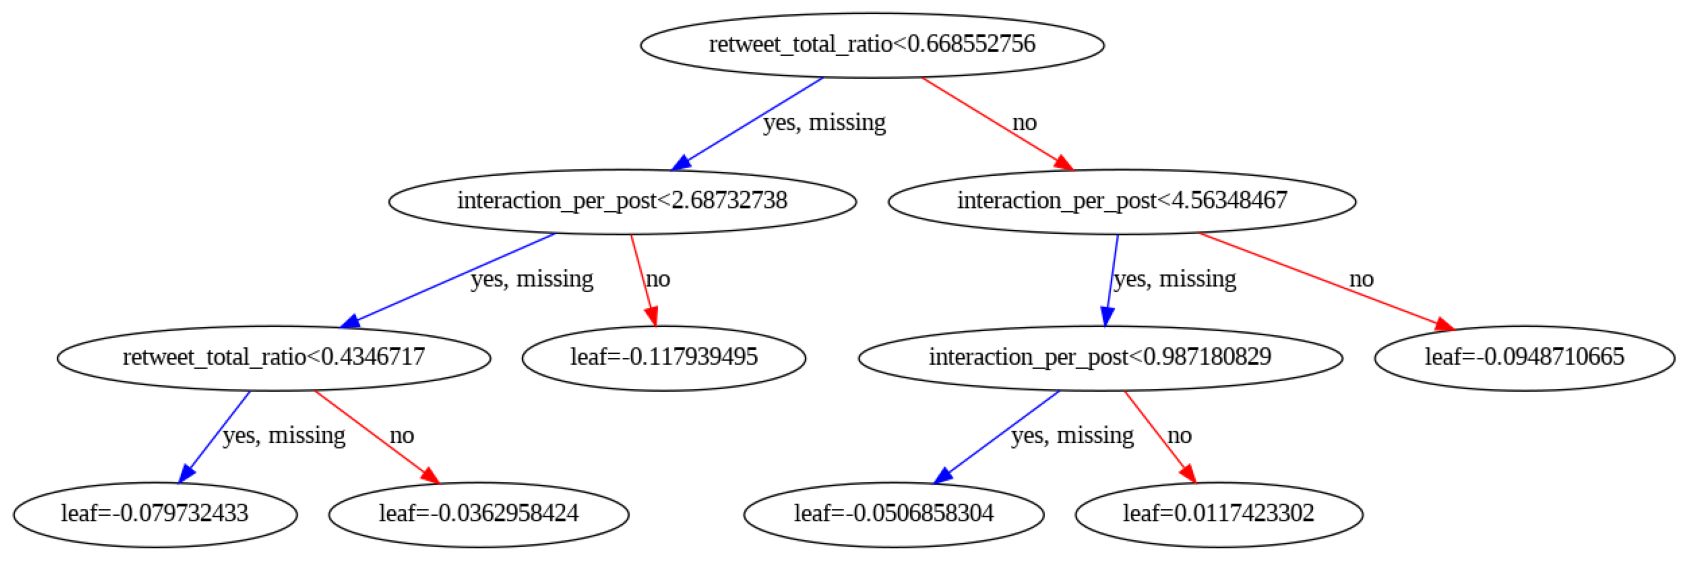

In [116]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(bot_model, num_trees=7, ax=ax)
plt.show()

# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [154]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv('{}evaluation-round{}-tweet.csv'.format(DATA_PATH,ROUND), dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfPolitical_test[['num_political_entities', 'check_description_politcal', 'num_mentions', 'total_interactions', 'num_hashtags', 'ratio_of_political','num_retweets',
              'num_favorites']]

# make predictions based on these variables
print(politic_model)
preds =politic_detect.predict(X)

count = 0
for pred_no,index in zip(range(len(preds)),X.index):

  

  #if preds[i] < 0.5:
  # if y_valid.iloc[pred_no] == 1 and X.iloc[pred_no].num_political_entities > 3:
  #   print('Prediction:',preds[pred_no], 'True Label:',y_valid.iloc[pred_no])

  if 'alimahir' in dfPolitical_test.loc[index,'text']:
    preds[pred_no] = 1
  if 'imamoğlu' in dfPolitical_test.loc[index,'text']:
    preds[pred_no] = 0.9
  if 'ak parti' in dfPolitical_test.loc[index,'text']:
    preds[pred_no] = 1
  if 'erdoğan' in dfPolitical_test.loc[index,'text']:
    preds[pred_no] = 0.95
  if 'millet ittifakı' in dfPolitical_test.loc[index,'text']:
    preds[pred_no] = 0.95 
  if 'gazete' in dfPolitical_test.loc[index,'text'].lower() and  X.iloc[pred_no].num_political_entities ==0 :
    preds[pred_no] = 0.6
    # print('Prediction:',preds[pred_no], 'True Label:',y_valid.iloc[pred_no], 'Num of political words:',X.iloc[pred_no].num_political_entities)
    # print('Text:',dfPolitical_test.loc[index,'text'])
  if 'yenisafak' in dfPolitical_test.loc[index,'text'].lower() and X.iloc[pred_no].num_political_entities ==0  :
    preds[pred_no] = 0.5
  
  if X.iloc[pred_no].num_political_entities >= 4:
    preds[pred_no] = 1

  if 'yenisafak' in dfPolitical_test.loc[index,'text'].lower() and X.iloc[pred_no].num_political_entities ==0  :
    preds[pred_no] = 0.5
  if 'İYİ ' in dfPolitical_test.loc[index,'text'] and 'Mamak' in dfPolitical_test.loc[index,'text']:
    preds[pred_no] = 1

  if ('cumhurbaşkan' in dfPolitical_test.loc[index,'text'].lower() or 'RTErdogan' in dfPolitical_test.loc[index,'text'].lower() )and X.iloc[pred_no].num_political_entities <=2:
    preds[pred_no] = 0.85
  if ('cumhurbaşkan' in dfPolitical_test.loc[index,'text'].lower() or 'RTErdogan' in dfPolitical_test.loc[index,'text'].lower() ) and X.iloc[pred_no].num_political_entities >=3:
    preds[pred_no] = 1
  if 'öğret' in dfPolitical_test.loc[index,'text'].lower() and preds[pred_no] < 0.85 :
    preds[pred_no] = 0.85
  if len(dfPolitical_test.loc[index,'text'])<30 and '@' not in dfPolitical_test.loc[index,'text'] and '#' not in dfPolitical_test.loc[index,'text'] :
    preds[pred_no] = 0


  if preds[pred_no] <0.3 and '#' not in dfPolitical_test.loc[index,'text'] and'@' not in dfPolitical_test.loc[index,'text'] :
    preds[pred_no] = 0




predictions_political = preds
predictions_political

XGBRegressor(colsample_bytree=0.5, gamma=0.9, learning_rate=0.5,
             objective='binary:logistic', reg_alpha=0.01, reg_lambda=7,
             subsample=0.6)


array([0.29542124, 0.25939092, 1.        , ..., 0.29542124, 0.21542095,
       1.        ], dtype=float32)

### This part is important! We expect you to return your predictions in the following format:

In [155]:
modelPredTweet = dict([(x,float(y)) for x,y in zip([*dfPolitical_test.tweet_id], predictions_political)])
modelPredTweet

{'1434787703783051264': 0.2954212427139282,
 '1367571642604544000': 0.2593909204006195,
 '1589993032975544320': 1.0,
 '1565312596135354373': 0.8218331336975098,
 '1579558096833511424': 0.9059044122695923,
 '1439547067337256967': 0.22790084779262543,
 '1559963768372740098': 0.9292605519294739,
 '1562853131251118081': 1.0,
 '1586021183958704128': 0.9269235134124756,
 '1585766233491886081': 0.2954212427139282,
 '1427746815420604417': 0.0,
 '1352635736537882629': 0.24006932973861694,
 '1415032260571680768': 0.2954212427139282,
 '1548636597628899328': 0.924176037311554,
 '1564926450096013313': 0.0,
 '1585634359612420101': 1.0,
 '1597138789108895744': 0.8614915013313293,
 '1391681495622995971': 0.14394564926624298,
 '1389951943343316995': 0.2154209464788437,
 '1452348722810138646': 0.2495226114988327,
 '1595829502021623812': 0.8512526750564575,
 '1413108476348354562': 0.2154209464788437,
 '1579408398894137344': 1.0,
 '1570758749606019073': 0.8524917960166931,
 '1366091745772077058': 0.0,
 '1

## 3.2. Predictions for Users (Bot or Not)

In [182]:
evaluationUserDf = pd.read_csv('{}evaluation-round{}-user.csv'.format(DATA_PATH,ROUND), dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfBot_test[['description_len','user_followers_count', 'user_friends_count',
                    'followers_to_all_ratio', 
                    'retweet_total_ratio',
                    'num_median_favorites',
                    'num_mean_duplicate_post',
                    'number_of_duplicated_posts',
                    'interaction_per_post',
                    'mentions_per_post',
                    'different_sources_used',
                    'like_per_post',
                    'tweet_per_day',
                    'total_tweet_count',
                    'is_verified',
                    'is_default_profile_image',
                    'is_default_profile'
                    ]]

# make predictions based on these variables

preds_bot =bot_model.predict(X)


for pred_no,index in zip(range(len(preds_bot)),X.index):

  if  X.iloc[pred_no].is_verified == 1:
    preds_bot[pred_no] = 0 
  

predictions_bot = preds_bot

In [183]:
modelPredUser = dict([(x,float(y)) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])
modelPredUser

{'biologselim': 0.06841382384300232,
 'omerakdag34': 0.02729680761694908,
 'bilgin21604923': 0.06862258166074753,
 '_sydneycarton_': 0.05350109934806824,
 'denizlihabercom': 0.05014743283390999,
 'burakerbaychp': 0.016361303627490997,
 'mvnez': 0.051781218498945236,
 'qara118': 0.021512819454073906,
 'nabiyonyevrum': 0.021933339536190033,
 'farukhalit2': 0.06632101535797119,
 'harlunoshi': 0.05164080858230591,
 'heritagepaix': 0.035364869982004166,
 'nuranwolf': 0.03188322111964226,
 'politikgundem': 0.0627388209104538,
 'isakethudax': 0.0,
 'enveraysevera': 0.0,
 'ilaydejaneiro': 0.03159802034497261,
 '1905anason': 0.18405166268348694,
 'eraydurgut03': 0.0351547934114933,
 'dasiskein': 0.035770464688539505,
 'ercan_bas29': 0.06752679497003555,
 'mett_1907': 0.031145399436354637,
 'ondemir066': 0.28305482864379883,
 'semihyeteer': 0.03544380143284798,
 'haberinyokcokk': 0.07468435168266296,
 'meleky_ozaydin': 0.07423339039087296,
 'mehmetaltay64': 0.0,
 'nurtencam2': 0.1283599287271499

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

In [184]:
# Explain your approach

data_explanations = '''
Explain here how you handle data for training
For the training, i apply some mappings and vectorized some of the textual data to the numerical. Eliminated the null values. And tried some hypothesis testing and data visualization to see the effects of the features to the label,
After done with these steps i decided which features to use (depending on the hypothesis testing results, calculating z-score and p-values) then visualazing the features and their correlations.
After all of these, the data were ready to train and i split the data to train and validation and tried to find the best model by doing parameter tuning for the test data.
And at the end i go to the model selection part which is explained in the model_explanations.

'''

feature_explanations = '''
What types of features you created
For the tweets:
i added the language feature but i decided not to use it since there is not much affect on the decision.
i also added how much a tweet is political by checking the description of the user, also checking how much of the tweet consist of political word(political word ratio)
Also i add a feature that checks whether tweet is retweeted from a political entity or not.

For the users:

'num_mean_duplicate_post' -> gives in avarage how much is the post is duplicated (posted multiple times)
'number_of_duplicated_posts', -> how many post is duplicated
'interaction_per_post', -> how much interaction (like + retweet) that each post gets
'mentions_per_post', -> how much mention is used in each post
'different_sources_used', -> how many different sources that user used while sending his tweets
'like_per_post', -> number of likes each post of the user gets
'tweet_per_day', -> how much tweet that is sent by the user
'total_tweet_count', -> how much tweet does user sent
'is_verified', -> is the account of the user is verified or not
'is_default_profile_image', -> is the profile image of the user is default or not
'is_default_profile' -> is the profile of the user is default or not

these are features for the users that i use.

---------------2ND ROUND------------------------------------------------

for the users i also added follower count and friends count as feature so that i got more accurate results.

'''

model_explanations = '''
What did you try and used for modeling
I tried random forest, decision tree, logistic regression, naive bayesian and XGBregressor as model, and most of them work considerably well, however the most accurate model with the parameter tuning was the XGBregressor therefore i used it for modelin. I also tried to stacking, 
to combine the results of random forest and XGBregressor but they decreased the performance. Therefore i prefered XGBregressor.

---------------2ND ROUND------------------------------------------------
Tried many other models SVM, Naive bayesian, adaBoost
and tried to combine them in spesific cases that i think xgboost was not self-sufficient. 

'''

additional_explanations = '''
Any other tricks that you tried for the project

i tried many tricks while both creating models, combining different predictions of the models. I tried to combine different combinations of the model and get a prediction. However for tweets there were a problem about if 
the tweet is political or not. I was unable to user some of the techniques that i used because of the fact that nearly %5-10 of the tweets are labeled wrong according to my examinations. Therefore i tried some regression models and combine them which
gave me better results.
---------------2ND ROUND------------------------------------------------
For the tweets, i used many other models in spesific cases, i also interfene and changed some probabilities so that the predictions are formed better.

'''


In [185]:
predictions = {
    'round': ROUND,
    'student_id': STUDENT_ID,
    'user_predictions': modelPredUser,
    'tweet_predictions': modelPredTweet,
    'explanations': {
        'data': data_explanations,
        'feature': feature_explanations,
        'model': model_explanations,
        'other': additional_explanations,
    }
}
#predictions-27943_round1.json

with open('predictions-{}_round{}.json'.format(STUDENT_ID, ROUND), 'w') as fl:
    fl.write(json.dumps(predictions, indent=4))

In [186]:
# Test your submission file

submission = json.load(open('predictions-{}_round{}.json'.format(STUDENT_ID, ROUND), 'r'))
submission

{'round': 3,
 'student_id': '27943',
 'user_predictions': {'biologselim': 0.06841382384300232,
  'omerakdag34': 0.02729680761694908,
  'bilgin21604923': 0.06862258166074753,
  '_sydneycarton_': 0.05350109934806824,
  'denizlihabercom': 0.05014743283390999,
  'burakerbaychp': 0.016361303627490997,
  'mvnez': 0.051781218498945236,
  'qara118': 0.021512819454073906,
  'nabiyonyevrum': 0.021933339536190033,
  'farukhalit2': 0.06632101535797119,
  'harlunoshi': 0.05164080858230591,
  'heritagepaix': 0.035364869982004166,
  'nuranwolf': 0.03188322111964226,
  'politikgundem': 0.0627388209104538,
  'isakethudax': 0.0,
  'enveraysevera': 0.0,
  'ilaydejaneiro': 0.03159802034497261,
  '1905anason': 0.18405166268348694,
  'eraydurgut03': 0.0351547934114933,
  'dasiskein': 0.035770464688539505,
  'ercan_bas29': 0.06752679497003555,
  'mett_1907': 0.031145399436354637,
  'ondemir066': 0.28305482864379883,
  'semihyeteer': 0.03544380143284798,
  'haberinyokcokk': 0.07468435168266296,
  'meleky_ozay